# Day-Averaged Yearly Profiles clustering

In [ ]:
import polars as pl
import re
import glob
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import logging
from datetime import date, datetime
from datetime import timedelta
from pathlib import Path

from tslearn.clustering import TimeSeriesKMeans 
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

from validation import validation_kMeans
from Hyperparameters_KMeans import optimize_kmeans

logging.getLogger('matplotlib.font_manager').disabled = True

timestamp_range = pl.datetime_range(datetime(2024, 1, 1), datetime(2024, 12, 31), "1d", eager=True).cast(pl.Date)

dataset = "SWW"    # Options: "SWW", "GroupE"
building_type = "all" # "flat", "house", "all"
number_of_clusters = 4

## Extracting and preparing files for clustering

In [9]:
def day_avg_preprocess(df, timestamp_range):
    
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )
    
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.date().alias("date")
    )

    date_list = timestamp_range.to_list()

    day_avg = (
        df.filter(pl.col("date").is_in(date_list))
          .group_by("date")
          .agg(pl.col("bruttolastgang_kwh").mean().alias("day_avg_bruttolastgang_kwh"))
          .sort("date")
    )
    return day_avg

def normalize(df):
    """ Normalize the 'day_avg_bruttolastgang_kwh' column by its max value and overwrite the original column """
    
    max_val = df.select(pl.max("day_avg_bruttolastgang_kwh"))['day_avg_bruttolastgang_kwh'][0]
    
    if max_val == 0:
        # Avoid division by zero, leave values unchanged
        df = df.with_columns(
            pl.col("day_avg_bruttolastgang_kwh")
        )
    else:
        # Overwrite original column with normalized values
        df = df.with_columns(
            (pl.col("day_avg_bruttolastgang_kwh") / max_val).alias("day_avg_bruttolastgang_kwh")
        )
    
    df = df.sort("date")
    
    return df

# Define the input file pattern
pattern = (f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/SM_DATA_cleaned/*.csv')
file_paths = glob.glob(pattern)

# Define the output directory
output_dir = Path(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/SM_DATA_day_avg_normalized")
output_dir.mkdir(parents=True, exist_ok=True)

for file_path in file_paths:
    df = pl.read_csv(file_path)
    day_avg = day_avg_preprocess(df, timestamp_range)
    day_avg = normalize(day_avg)
    
    filename = os.path.basename(file_path)  # gets file name with extension
    output_file = output_dir / filename      # construct output path
    
    day_avg.write_csv(output_file)

## Daily-average Clustering over the year 2024

In [11]:
file_path = (f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/Survey_Data/Survey_Data_{dataset}.xlsx")

if dataset == "SWW":
    df = pd.read_excel(file_path,skiprows=4,nrows=1500,header=None,dtype={10: str, 142: str})
    cols_to_extract = [10, 142]
elif dataset == "GroupE":
    df = pd.read_excel(file_path,skiprows=3,nrows=1500,header=None,dtype={0: str, 148: str})
    cols_to_extract = [0, 148]


extracted_df = df.iloc[:, cols_to_extract]

# Assign your own headers
extracted_df.columns = ['resident_id', 'Building Type']

extracted_df_pl = pl.from_pandas(extracted_df)

total_rows = extracted_df_pl.height

# Count unique house_id values
unique_resident_ids = extracted_df_pl["resident_id"].n_unique()

print(f"Total rows: {total_rows}")
print(f"Unique resident_id count: {unique_resident_ids}")

if total_rows > unique_resident_ids:
    print(f"There are {total_rows - unique_resident_ids} duplicate house_id entries.")
else:
    print("No duplicates found in house_id column.")

category_df = extracted_df.copy()
rows_to_keep_indices = []
exclude_building_type = building_type

if building_type == "all":
    exclude_building_type = None
elif building_type == "house":
    exclude_building_type = "Flat"
elif building_type == "flat":
    exclude_building_type = "House"

if building_type != "all":
    for i, row in category_df.iterrows():
        # Check if 'No Information' NOT in any value of that row
        if "No Information" not in row.values:
            # Check if 'Flat' NOT in any value of that row
            if exclude_building_type not in row.values:
                rows_to_keep_indices.append(i)
else:
    for i, row in category_df.iterrows():
        rows_to_keep_indices.append(i)

category_df = category_df.drop(columns=['Building Type'])
#category_df = category_df.drop(columns=['resident_id'])

category_df = category_df.iloc[rows_to_keep_indices]
print(category_df)

Total rows: 1500
Unique resident_id count: 1500
No duplicates found in house_id column.
     resident_id
0          10015
1          10030
2          10135
3          10207
4          10219
...          ...
1495      535554
1496      617505
1497      621182
1498      643884
1499         NaN

[1500 rows x 1 columns]


In [15]:

input_folder = Path(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/SM_DATA_day_avg_normalized")

# Alle CSV-Dateien
pattern = str(input_folder / "*.csv")
file_paths = glob.glob(pattern)

data_list = []
filename_list = []

# gültige IDs aus category_df als Strings
valid_ids = set(category_df["resident_id"].astype(str))

print(valid_ids)

for file_path in file_paths:
    df = pl.read_csv(file_path)

    base = os.path.basename(file_path)
    resid, _ = os.path.splitext(base)

    if resid not in valid_ids:
        continue

    n_timestamps = df["day_avg_bruttolastgang_kwh"].shape[0]
    
    values_array = (
        df["day_avg_bruttolastgang_kwh"]
        .to_numpy()
        .reshape((1, n_timestamps, 1))
    )
    data_list.append(values_array)
    filename_list.append(resid)

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")
    train_data = data_3d
else:
    train_data = None
    print("No matching files with correct length found.")

{'34279', '60772', '16783', '38678', '61615', '44794', '29635', '63187', '34915', '69094', '27772', '17041', '29479', '52201', '49747', '60232', '65353', '63934', '65788', '53773', '74623', '32776', '58687', '34474', '54019', '46168', '47929', '38872', '38875', '66436', '30034', '41872', '45589', '26074', '50941', '37156', '33025', '20380', '10786', '56185', '13579', '56149', '69820', '65308', '60739', '70258', '10207', '34339', '59086', '73387', '74197', '58996', '74896', '66160', '21310', '59104', '32833', '59095', '17338', '70459', '23161', '29458', '35425', '35977', '22645', '15082', '35569', '46906', '22606', '27202', '74425', '11128', '26866', '28357', '56440', '31312', '73915', '40855', '14983', '52528', '58471', '34414', '19432', '27919', '37183', '75154', '24541', '53137', '67549', '45094', '43093', '68863', '31816', '25825', '74605', '54892', '51538', '27574', '58177', '42931', '23032', '61030', '53821', '71593', '14755', '17413', '45628', '26695', '47242', '73051', '29896', 

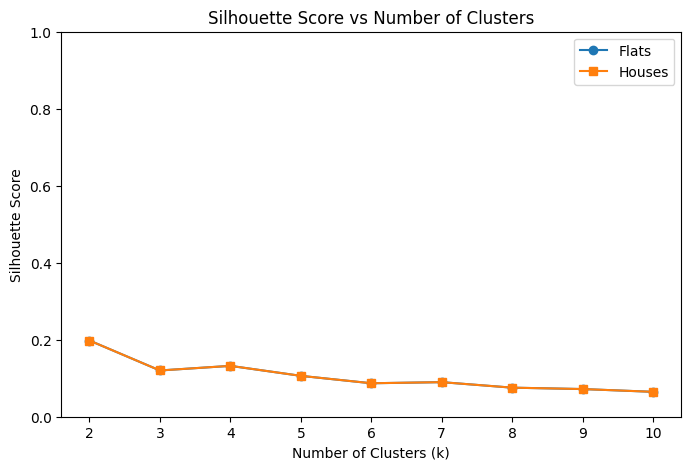

Minimum Silhouette Score Dataset 1: 0.19795310698769616
Minimum Silhouette Score Dataset 2: 0.19795310698769616

Best combination of hyperparameters:
n_clusters                  4
init                k-means++
n_init                      2
max_iter                  500
silhouette_score     0.132108
db_score             1.995559
Name: 34, dtype: object


n_clusters                  4
init                k-means++
n_init                      2
max_iter                  500
silhouette_score     0.132108
db_score             1.995559
Name: 34, dtype: object

In [16]:
validation_kMeans(train_data,train_data, dataset)

optimize_kmeans(train_data)


In [17]:
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=number_of_clusters,max_iter=max_iterations, verbose=False, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

In [18]:
# saves the found clusters in a csv file with the corresponding household IDs

# Convert filename_list items to strings
resident_ids = [str(h) for h in filename_list]

# Creates Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "resident_id": resident_ids,
    "cluster": clusters_train + 1
}).sort("cluster")
result_df.write_csv(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/day_avg_clustering.csv')

In [19]:
# total number of households per cluster, total energy consumption per cluster, averga eenergy consumption per cluster daily and anually

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/alle_mittelwerte.csv")  # Adjust path as needed

# Normalize keys in all DataFrames for clean join
# Normalize keys
result_df = result_df.with_columns(
    pl.col("resident_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("resident_id")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("resident_id")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "resident_id",
        "bruttolastgang_kwh_sum",
        "average_daily_consumption"
    ]),
    on="resident_id",
    how="left"
)
# Now select in the desired order
result_df = result_df.select([
    "resident_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_daily_consumption"  
])

#print(result_df.head())

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("resident_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_yearly_consumption [kWh]"),
    pl.mean("average_daily_consumption").alias("avg_daily_consumption [kWh]")
]).sort("cluster")

print(cluster_summary)

shape: (5, 4)
┌─────────┬────────────────┬──────────────────────────────┬─────────────────────────────┐
│ cluster ┆ num_households ┆ avg_yearly_consumption [kWh] ┆ avg_daily_consumption [kWh] │
│ ---     ┆ ---            ┆ ---                          ┆ ---                         │
│ i64     ┆ u32            ┆ f64                          ┆ f64                         │
╞═════════╪════════════════╪══════════════════════════════╪═════════════════════════════╡
│ 1       ┆ 175            ┆ 3385.983017                  ┆ 5.571397                    │
│ 2       ┆ 247            ┆ 5886.247664                  ┆ 10.499844                   │
│ 3       ┆ 174            ┆ 11567.514655                 ┆ 17.919136                   │
│ 4       ┆ 422            ┆ 2838.471934                  ┆ 4.869438                    │
│ 5       ┆ 463            ┆ 3845.174801                  ┆ 6.588853                    │
└─────────┴────────────────┴──────────────────────────────┴───────────────────────────

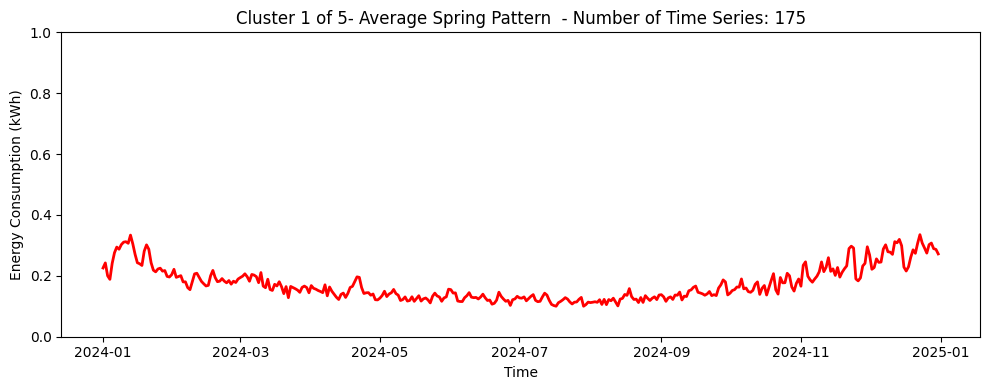

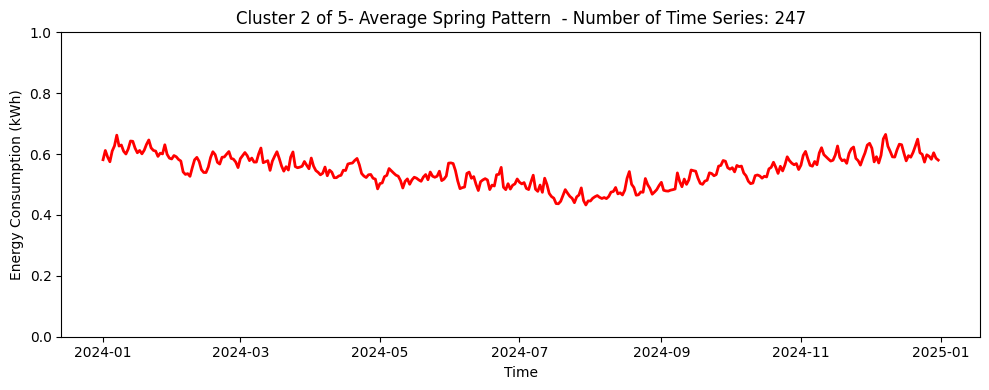

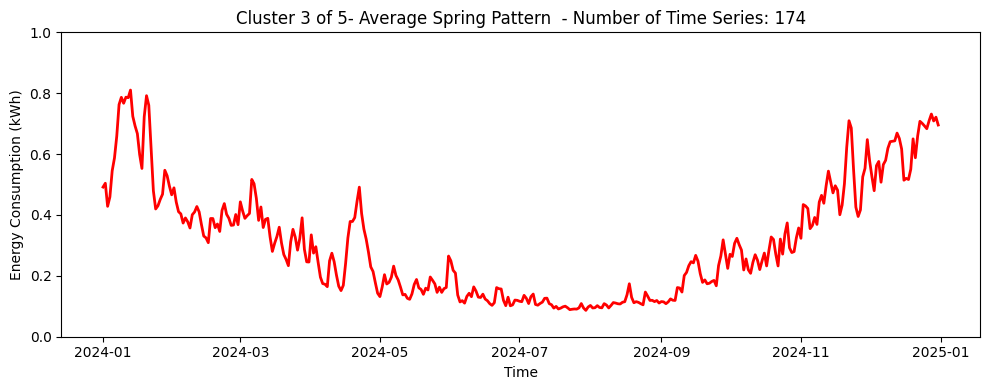

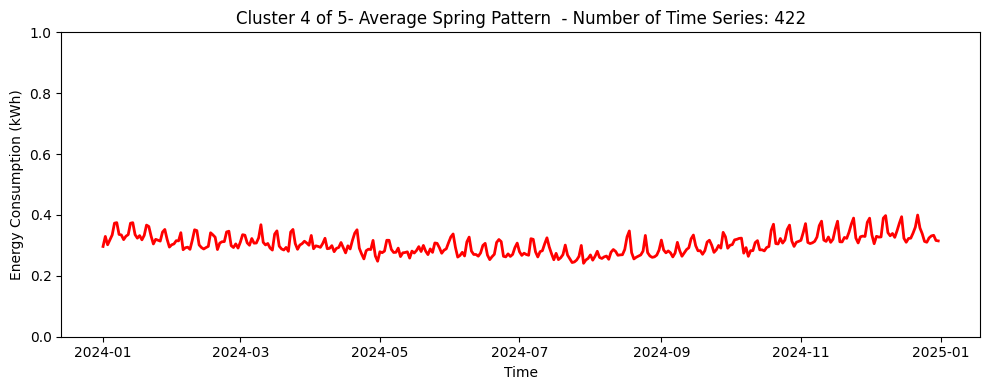

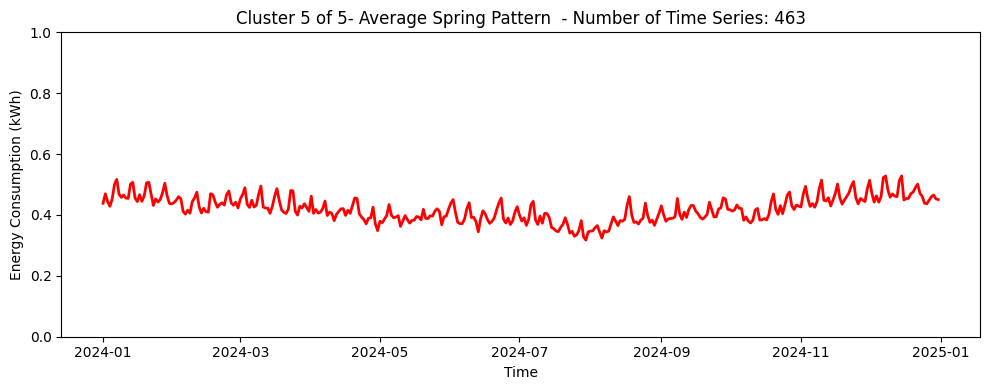

In [20]:
save = 0 #if you want to save the plots save = 1 and add path
plot_range = timestamp_range

n_clusters_to_plot = np.unique(clusters_train)
n_clusters = len(n_clusters_to_plot)

for cluster_idx in range(n_clusters):
    # Get all time series in this cluster
    cluster_data = train_data[clusters_train == cluster_idx]
    cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
    # Calculate the mean time series for the cluster
    mean_time_series = np.mean(cluster_data, axis=0)
    
    # Plot the mean time series
    plt.figure(figsize=(10, 4))

    plt.plot(plot_range, mean_time_series.ravel(), linewidth =2, color='red' )
    cluster_no = cluster_idx+1
    plt.title(f"Cluster {cluster_no} of {n_clusters}- Average Spring Pattern  - Number of Time Series: {len(cluster_indices)}")
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption (kWh)")
    plt.xticks()
    plt.ylim(0,1)
    plt.tight_layout()
    #plt.legend()
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()